### ***Contributed By:-***
Divyanshi Bhojak

Tarushi Jat 
### **Notebook III: Training Machine Learning Models.**

****

### **Libraries Used**

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import chain
from collections import Counter 
import scipy as sp
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib
import pickle
!pip install imblearn
from imblearn.over_sampling import SMOTE

### **Loading data that was created in NoteBook-II**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
yelp = pd.read_csv("/content/drive/MyDrive/IT750/Extracted_yelpdata/Combine/yelp_load.csv")

**Searching out common words in true & fake reviews**

In [ ]:
non_dec = yelp[yelp['Label']== 1]
dec = yelp[yelp['Label'] == -1]
non_dec_words = []

for i in range(0,non_dec['Review'].count()):
   non_dec_temp = non_dec['Review'].iloc[i].split()
   non_dec_words.append(non_dec_temp)

list1 = list(chain.from_iterable(non_dec_words))
dec_words= dec['Review'].str.split(expand=True).stack()

dec_most_common = Counter(list1).most_common()
non_dec_most_common = Counter(dec_words).most_common()

In [ ]:
deceptive = pd.DataFrame(dec_most_common)
non_deceptive = pd.DataFrame(non_dec_most_common)
non_deceptive = non_deceptive[0:23]
deceptive = deceptive[0:23]
same_words = list(set(deceptive.iloc[:,0]) & set(non_deceptive.iloc[:,0]))

### **Method for Plotting Confusion Matrix**

In [ ]:
def display_cm(y_test, model_pred):
  CM = confusion_matrix(y_test, model_pred)
  f, ax = plt.subplots(figsize=(5,5))
  sns.heatmap(CM,annot = True, linewidths=0.5,linecolor="white",fmt=".0f",ax=ax, cmap=plt.cm.copper)
  plt.xlabel("Prediction(Ypred)")
  plt.ylabel("Ytrue")
  plt.show()

### **Method for Displaying Performance Metrics**

In [ ]:
def display(y_test, model_pred):
  #print("-----------------------------------------------------------")
  print("Accuracy Score :-", accuracy_score(y_test, model_pred))
  #print("-----------------------------------------------------------")
  print("roc_auc Score :-", roc_auc_score(y_test, model_pred))
  #print("-----------------------------------------------------------")
  print("Classification Report:-")
  print()
  print(classification_report(y_test, model_pred))

### **Spliting Dataset into Train and Test**

In [ ]:
yelp_train =  yelp.drop(columns=['User_Id','Prod_Id','Date_x','Product_Name','compound'])
yelp_train =  yelp_train.dropna()
yelp = yelp.dropna()

In [ ]:
all_Xtrain, all_Xtest, Y_train, Y_test = train_test_split(yelp_train, yelp['Label'], test_size=0.20, random_state=101)

In [ ]:
vectorizer = TfidfVectorizer(stop_words= same_words, ngram_range=(3,3), max_features= 15000)
vectorize = vectorizer.fit(all_Xtrain['Review'])

reviewVector_x_train = vectorize.transform(all_Xtrain['Review'])
reviewVector_x_test = vectorize.transform(all_Xtest['Review'])

In [ ]:
X_train = sp.sparse.hstack((reviewVector_x_train,all_Xtrain[['Rating','Avg_Prod_Rating','Avg_user_rating','Review_Len','user_total_reviews','neg','neu','pos','number_Cap_Words','number_digit_Words','noun_count']].values),format='csr')
X_test = sp.sparse.hstack((reviewVector_x_test,all_Xtest[['Rating','Avg_Prod_Rating','Avg_user_rating','Review_Len','user_total_reviews','neg','neu','pos','number_Cap_Words','number_digit_Words','noun_count']].values),format='csr')

## **Oversampling Technique**


### **SMOTE**

In [ ]:
method = SMOTE(kind='regular')
X_resampled, y_resampled = method.fit_sample(X_train, Y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


### **1. Decision Tree with SMOTE**

In [ ]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_resampled, y_resampled)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
d_pred = decision_tree.predict(X_test)

In [ ]:
display(Y_test, d_pred)

Accuracy Score :- 0.8895967720527727
roc_auc Score :- 0.8737112622660815
Classification Report:-

              precision    recall  f1-score   support

          -1       0.84      0.83      0.83     25116
           1       0.91      0.92      0.92     50226

    accuracy                           0.89     75342
   macro avg       0.88      0.87      0.88     75342
weighted avg       0.89      0.89      0.89     75342



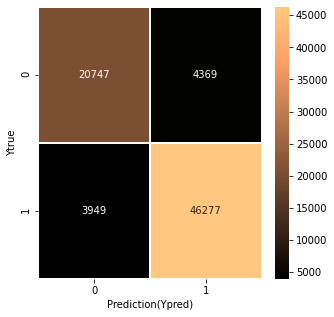

In [ ]:
display_cm(Y_test, d_pred)

### **2. Bagging with SMOTE**

In [ ]:
bag = BaggingClassifier()
bag.fit(X_resampled, y_resampled)

BaggingClassifier(base_estimator=None, bootstrap=True, bootstrap_features=False,
                  max_features=1.0, max_samples=1.0, n_estimators=10,
                  n_jobs=None, oob_score=False, random_state=None, verbose=0,
                  warm_start=False)

In [ ]:
bag_pred = bag.predict(X_test)

In [ ]:
display(Y_test, bag_pred)

Accuracy Score :- 0.8947068036420589
roc_auc Score :- 0.8760410921611858
Classification Report:-

              precision    recall  f1-score   support

          -1       0.86      0.82      0.84     25116
           1       0.91      0.93      0.92     50226

    accuracy                           0.89     75342
   macro avg       0.88      0.88      0.88     75342
weighted avg       0.89      0.89      0.89     75342



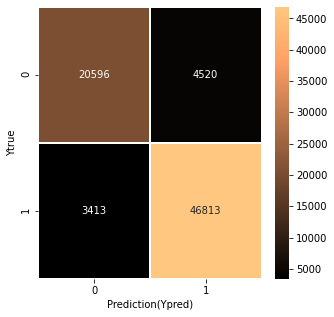

In [ ]:
display_cm(Y_test, bag_pred)

### **3. Random Forest with SMOTE**

In [ ]:
rf = RandomForestClassifier(criterion='entropy', min_samples_leaf=100, min_samples_split=20)
rf = rf.fit(X_resampled, y_resampled)

In [ ]:
y_pred_test = rf.predict(X_test)

In [ ]:
display(Y_test, bag_pred)

Accuracy Score :- 0.9067850601258263
roc_auc Score :- 0.8878470698015919
Classification Report:-

              precision    recall  f1-score   support

          -1       0.88      0.83      0.86     25116
           1       0.92      0.94      0.93     50226

    accuracy                           0.91     75342
   macro avg       0.90      0.89      0.89     75342
weighted avg       0.91      0.91      0.91     75342



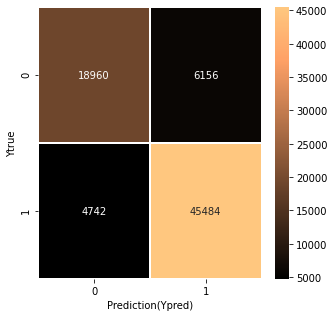

In [ ]:
display_cm(Y_test, y_pred_test)

### **4. KNN**

In [ ]:
knn = KNeighborsClassifier()
knn.fit(X_resampled, y_resampled)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [ ]:
knn_pred = knn.predict(X_test)

In [ ]:
display(Y_test, knn_pred)

Accuracy Score :- 0.8091370019378301
roc_auc Score :- 0.8092635501579682
Classification Report:-

              precision    recall  f1-score   support

          -1       0.68      0.81      0.74     25116
           1       0.89      0.81      0.85     50226

    accuracy                           0.81     75342
   macro avg       0.79      0.81      0.79     75342
weighted avg       0.82      0.81      0.81     75342



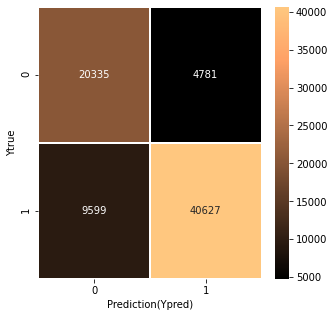

In [ ]:
display_cm(Y_test, knn_pred)

### **5. AdaBoost**

In [ ]:
boost =  AdaBoostClassifier()
boost.fit(X_resampled, y_resampled)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)

In [ ]:
boost_pred = boost.predict(X_test)

In [ ]:
display(Y_test, boost_pred)

Accuracy Score :- 0.8590029465636697
roc_auc Score :- 0.8445744465783888
Classification Report:-

              precision    recall  f1-score   support

          -1       0.78      0.80      0.79     25116
           1       0.90      0.89      0.89     50226

    accuracy                           0.86     75342
   macro avg       0.84      0.84      0.84     75342
weighted avg       0.86      0.86      0.86     75342



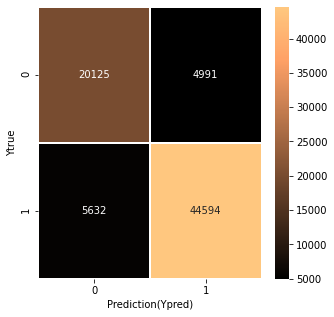

In [ ]:
display_cm(Y_test, boost_pred)

### **6. Majority Voting Classifier**

In [ ]:
voting_classifier = VotingClassifier(estimators=[('DT', decision_tree), ('Bagging', bag), ('RF', rf), ('KNN', knn), ('AdaBoost', boost)], voting='hard')
voting_classifier = voting_classifier.fit(X_resampled, y_resampled)
vc_pred = voting_classifier.predict(X_test)

In [ ]:
display(Y_test, vc_pred)

Accuracy Score :- 0.9067850601258263
roc_auc Score :- 0.8878470698015919
Classification Report:-

              precision    recall  f1-score   support

          -1       0.88      0.83      0.86     25116
           1       0.92      0.94      0.93     50226

    accuracy                           0.91     75342
   macro avg       0.90      0.89      0.89     75342
weighted avg       0.91      0.91      0.91     75342



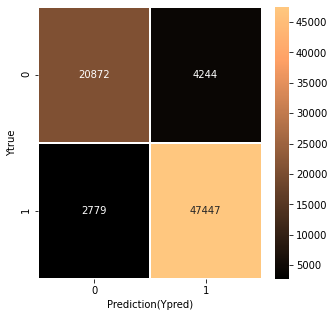

In [ ]:
display_cm(Y_test, vc_pred)

# **End.**